# Snowpack model </a><a name='top'>

This notebook is an example of how to use the developed model (layer detection and compaction model from lidar time-lapse data) on a typical dataset.

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

## Imports and functions

In [1]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 7, time 0).


## Define needed information to run the whole notebook </a><a name='fill-in'>

In [2]:
dataset_file_name = 'pit_7_2023.nc'

# Snow layers figure

nb_layers_to_plot = 25
figure_size = (20, 5)
save_fig_file = True
fig_file_name = '/home/mabonnet/github/MB_little_awk/finalized/Parameters_set/pit_7_kojima.png'

[Back to top section](#top)

## Define dataset and clean data

In [3]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(dataset_file_name)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7, y_span=7)
median_time_filtering(data_set_used, 11)

# Add the summer surface to the dataset

define_summer_surface(data_set_used, start_summer_surface, end_summer_surface)

# Redefine the zero of the dataset

data_set_used['snow_depth'] = data_set_used['snow_surface'] - data_set_used['summer_surface']       # TODO make NEW variable for this, snow_depth


---> Median filtering in space with a window [5, 7]
---> Median filtering in time with a window of 11
---> Summer surface defined based on scans from 2022-10-07 to 2022-10-15


## Get timing values

In [4]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

# Define the number of iterations based on duration of the data

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [5]:
# Get timing of events

results = get_snow_events(data_set_used, x_isel, y_isel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


## Simulate evolution of snowpack

In [6]:
# Simulate the snowpack

snowpack = simulate_snowpack_evolution(data_set_used, x_isel, y_isel, nb_iterations, max_nb_of_layers, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


## Plot results

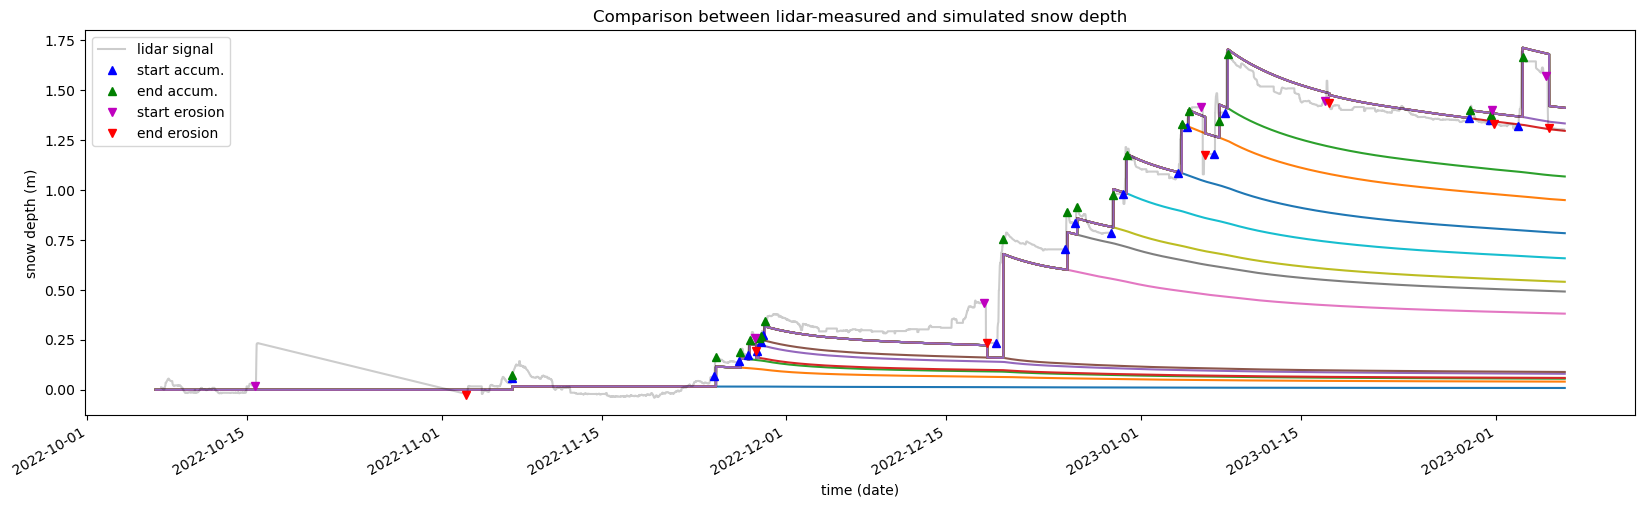

()

In [7]:
plot_simul_and_signal(data_set_used, x_isel, y_isel, depth_evolution, nb_layers_to_plot, pd.to_datetime(data_set_used.time.values[0]), dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, fig_figsize=figure_size, save_file=save_fig_file, fig_file_name=fig_file_name)


In [8]:
# Converting met_time to compatible units with temperature evolution plot

met_time_compatible = []

for time_index in range(len(met_time)):
    met_time_compatible.append(met_time[time_index]/100)

Text(0, 0.5, 'Temperature')

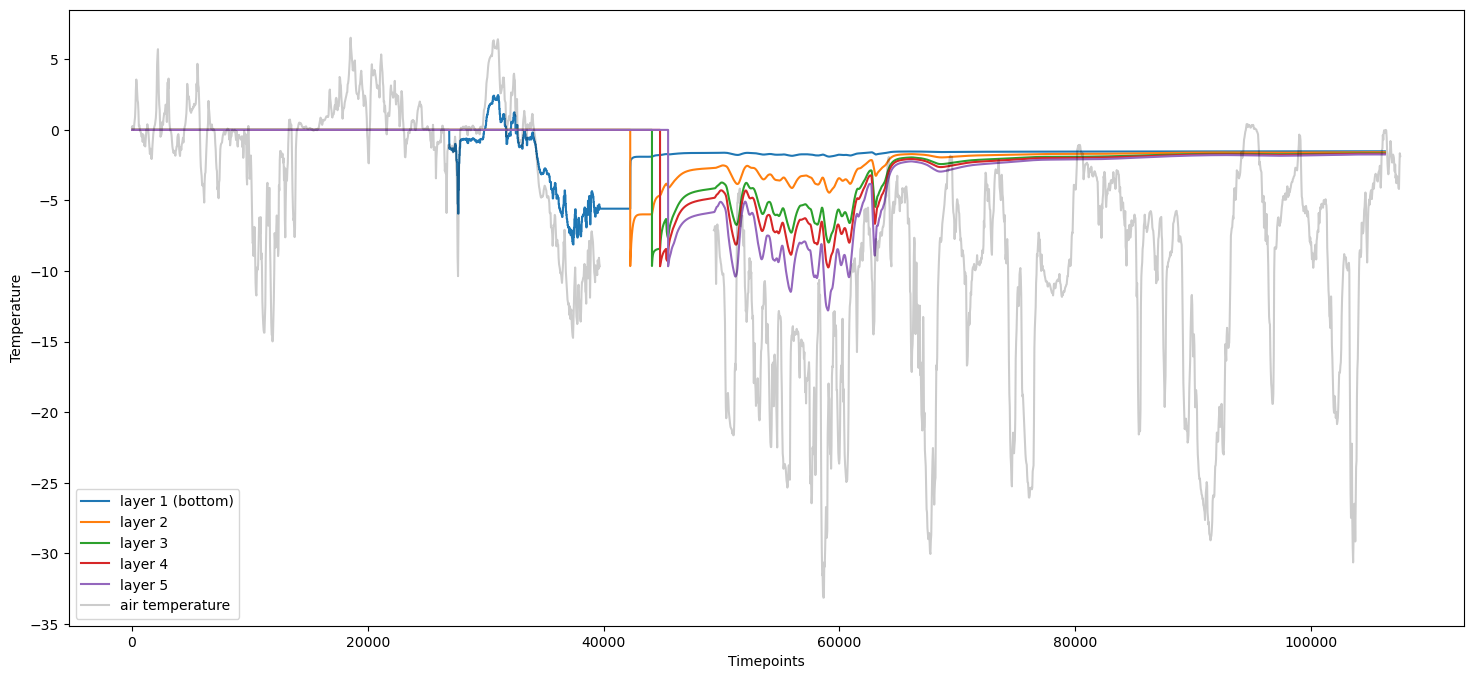

In [9]:
# Temperature

layer1 = np.array(temperature_evolution)[:,0]
layer2 = np.array(temperature_evolution)[:,1]
layer3 = np.array(temperature_evolution)[:,2]
layer4 = np.array(temperature_evolution)[:,3]
layer5 = np.array(temperature_evolution)[:,4]

plt.figure(figsize=(18, 8))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')

plt.plot(met_time_compatible, met_temp, c='k', alpha=0.2, label='air temperature')

plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')